In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install tensorflow_hub

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras import backend as K
from transformers import AutoTokenizer,TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy


sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train = train.drop(['keyword','location'], axis = 1)
test = test.drop(['keyword','location'], axis = 1)
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Checking Shape of Train and Test sets:
print("Shape of Train set:", train.shape)
print("Shape of Test set:", test.shape)

Shape of Train set: (7613, 3)
Shape of Test set: (3263, 2)


# Labels are as follows:
label '1' ---> racist/sexist tweet           
label '0' ---> not racist/sexist tweet

In [6]:
df = train.copy()
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# 1. Model without removing any feature:

### Splitting data into Train and Test sets

In [7]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

# BERT 
### Base Model with Neural Networks:

In [8]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4")

In [9]:
# Checking array created using BERT:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding(["You are noob.","What are you looking at?"])

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.99035466,  0.9815679 ,  0.9975458 , ..., -0.9994887 ,
        -0.5053125 ,  0.9433913 ],
       [ 0.9989152 ,  0.11918571,  0.8990445 , ..., -0.63001037,
        -0.9233927 ,  0.9344142 ]], dtype=float32)>

In [10]:
# Bert layers:
num_classes = 2
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers:
l = tf.keras.layers.Dropout(0.2, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(l)

# Construct final model:
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

# You can use these METRICS as well. If you are using this then change 'metrics=METRICS' in 'model.compile' section.
# METRICS = [
#            tf.keras.metrics.BinaryCrossentropy(name='accuracy'),
#            tf.keras.metrics.Precision(name='precision'),
#            tf.keras.metrics.Recall(name='recall')
# ]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [11]:
#Ploting Model Architecture:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Training model:

In [12]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 215s 1s/step - loss: 0.7281 - accuracy: 0.5660 - val_loss: 0.6863 - val_accuracy: 0.5222
Epoch 2/3
172/172 [==============================] - 213s 1s/step - loss: 0.6786 - accuracy: 0.6165 - val_loss: 0.6170 - val_accuracy: 0.6700
Epoch 3/3
48/48 [==============================] - 55s 1s/step - loss: 0.5943 - accuracy: 0.7315


[0.594302773475647, 0.7314510941505432]

### Results:

In [13]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[749  92]
 [317 365]]
              precision    recall  f1-score   support

           0       0.70      0.89      0.79       841
           1       0.80      0.54      0.64       682

    accuracy                           0.73      1523
   macro avg       0.75      0.71      0.71      1523
weighted avg       0.75      0.73      0.72      1523



### Accuracy vs Loss:

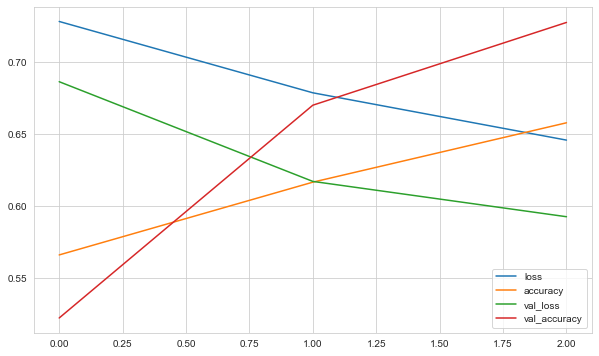

In [14]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

# 2. Model after removing stopwords:

In [15]:
df = train.copy()

### Removing Stopwords:

In [16]:
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

### Splitting data into Train and Test sets

In [17]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

### Training model:

In [18]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 223s 1s/step - loss: 0.6399 - accuracy: 0.6581 - val_loss: 0.5795 - val_accuracy: 0.7406
Epoch 2/3
172/172 [==============================] - 224s 1s/step - loss: 0.6155 - accuracy: 0.6853 - val_loss: 0.5783 - val_accuracy: 0.6979
Epoch 3/3
48/48 [==============================] - 56s 1s/step - loss: 0.5632 - accuracy: 0.7426


[0.5631568431854248, 0.7426132559776306]

### Results:

In [19]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[772  69]
 [323 359]]
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       841
           1       0.84      0.53      0.65       682

    accuracy                           0.74      1523
   macro avg       0.77      0.72      0.72      1523
weighted avg       0.76      0.74      0.73      1523



### Accuracy vs Loss:

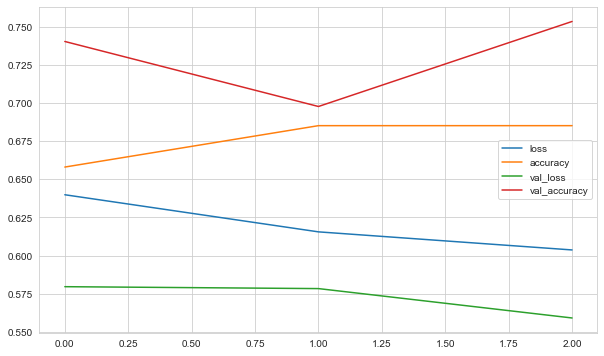

In [20]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

# 3. Model after removing repeating characters:

In [21]:
df = train.copy()

### Removing repeating characteres:

In [22]:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.text = df.text.apply(lambda tweet: reduce_sequence_tweet(tweet))

# Detokenizing tweets:

def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

df['text'] = df['text'].apply(lambda x: listToString(x))

### Splitting data into Train and Test sets

In [23]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

### Training model:

In [24]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 224s 1s/step - loss: 0.6013 - accuracy: 0.6933 - val_loss: 0.5582 - val_accuracy: 0.7323
Epoch 2/3
172/172 [==============================] - 224s 1s/step - loss: 0.5962 - accuracy: 0.6957 - val_loss: 0.5530 - val_accuracy: 0.7307
Epoch 3/3
48/48 [==============================] - 56s 1s/step - loss: 0.5803 - accuracy: 0.7091


[0.5803499221801758, 0.7091267108917236]

### Results:

In [25]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[815  26]
 [417 265]]
              precision    recall  f1-score   support

           0       0.66      0.97      0.79       841
           1       0.91      0.39      0.54       682

    accuracy                           0.71      1523
   macro avg       0.79      0.68      0.67      1523
weighted avg       0.77      0.71      0.68      1523



### Accuracy vs Loss:

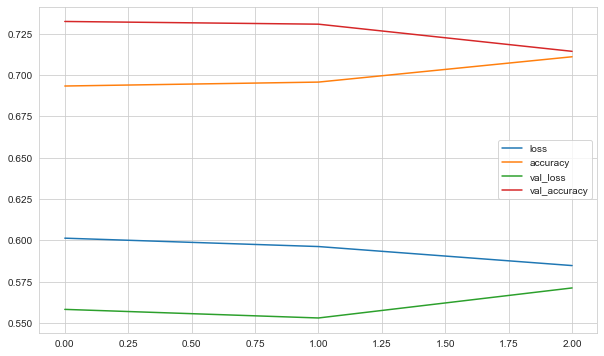

In [26]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

# 4. Model after removing Punctuations:

In [27]:
df = train.copy()

### Removing Punctuations:

In [28]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

### Splitting data into Train and Test sets

In [30]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

### Training model:

In [31]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 224s 1s/step - loss: 0.5948 - accuracy: 0.6960 - val_loss: 0.5571 - val_accuracy: 0.7291
Epoch 2/3
172/172 [==============================] - 224s 1s/step - loss: 0.5861 - accuracy: 0.7070 - val_loss: 0.5430 - val_accuracy: 0.7553
Epoch 3/3
48/48 [==============================] - 56s 1s/step - loss: 0.5462 - accuracy: 0.7531


[0.546191930770874, 0.7531188726425171]

### Results:

In [32]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[752  89]
 [287 395]]
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       841
           1       0.82      0.58      0.68       682

    accuracy                           0.75      1523
   macro avg       0.77      0.74      0.74      1523
weighted avg       0.77      0.75      0.75      1523



### Accuracy vs Loss:

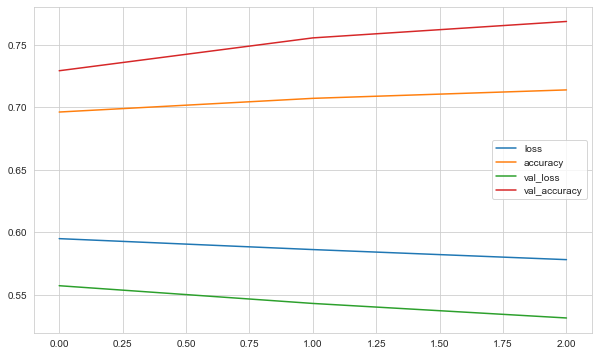

In [33]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

# 5. Model after removing numbers:

In [34]:
df = train.copy()

### Removing numbers:

In [35]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['text'] = df['text'].apply(lambda text: cleaning_numbers(text))

### Splitting data into Train and Test sets

In [36]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

### Training model:

In [37]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 225s 1s/step - loss: 0.5864 - accuracy: 0.7035 - val_loss: 0.6005 - val_accuracy: 0.6782
Epoch 2/3
172/172 [==============================] - 224s 1s/step - loss: 0.5824 - accuracy: 0.7053 - val_loss: 0.5496 - val_accuracy: 0.7258
Epoch 3/3
48/48 [==============================] - 56s 1s/step - loss: 0.5425 - accuracy: 0.7538


[0.5425163507461548, 0.753775417804718]

### Results:

In [38]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[710 131]
 [244 438]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       841
           1       0.77      0.64      0.70       682

    accuracy                           0.75      1523
   macro avg       0.76      0.74      0.75      1523
weighted avg       0.76      0.75      0.75      1523



### Accuracy vs Loss:

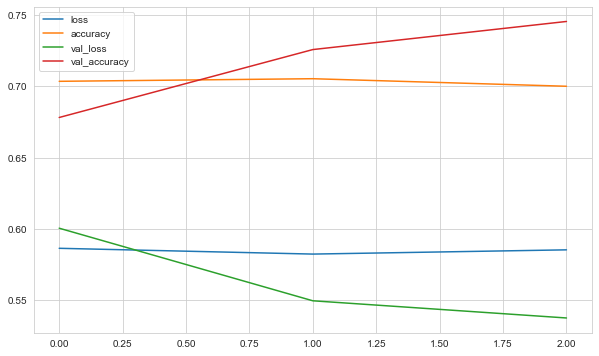

In [39]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

# Setup 6: Applying Stemming and Lemmatization:

In [40]:
df = train.copy()

### Applying Stemming: 

In [41]:
# Tokenizing tweets:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

stemm = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemm.stem(y) for y in x])

### Splitting data into Train and Test :

In [42]:
y = tf.keras.utils.to_categorical(df['target'].astype(str), num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'].astype(str), y, test_size=0.2, random_state=3)

### Training model:

In [43]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 223s 1s/step - loss: 0.6721 - accuracy: 0.6107 - val_loss: 0.6254 - val_accuracy: 0.6502
Epoch 2/3
172/172 [==============================] - 224s 1s/step - loss: 0.6547 - accuracy: 0.6203 - val_loss: 0.6753 - val_accuracy: 0.5977
Epoch 3/3
48/48 [==============================] - 56s 1s/step - loss: 0.6325 - accuracy: 0.6507


[0.6325399875640869, 0.650689423084259]

# Results:

In [44]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[456 385]
 [147 535]]
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       841
           1       0.58      0.78      0.67       682

    accuracy                           0.65      1523
   macro avg       0.67      0.66      0.65      1523
weighted avg       0.68      0.65      0.65      1523



### Accuracy vs Loss:

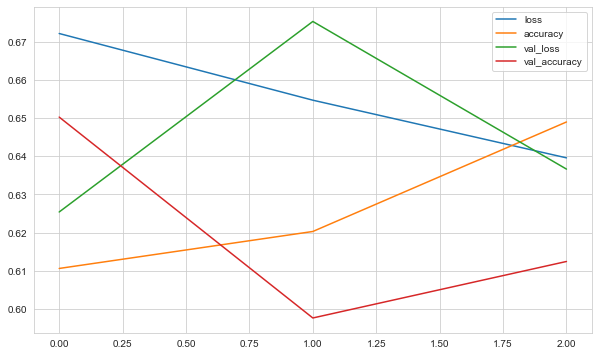

In [45]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

# 7. Models after removing all the features:

In [46]:
df = train.copy()

### Removing Punctuations:

In [47]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [48]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x))

### Removing Stopwords:

In [49]:
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

### Removing Numbers:

In [50]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['text'] = df['text'].apply(lambda text: cleaning_numbers(text))

### Removing repeating characters:

In [51]:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.text = df.text.apply(lambda tweet: reduce_sequence_tweet(tweet))

# Detokenizing tweets:

def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

df['text'] = df['text'].apply(lambda x: listToString(x))

### Applying Stemming: 

In [52]:
# Tokenizing tweets:
tokens = (word_tokenize(i) for i in df.text)
df['text'] = df['text'].apply(nltk.word_tokenize)

stemm = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemm.stem(y) for y in x])

### Splitting data into Train and Test sets

In [53]:
y = tf.keras.utils.to_categorical(df['target'].astype(str), num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'].astype(str), y, test_size=0.2, random_state=3)

### Training model:

In [54]:
history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
172/172 [==============================] - 223s 1s/step - loss: 0.6566 - accuracy: 0.6221 - val_loss: 0.6197 - val_accuracy: 0.6716
Epoch 2/3
172/172 [==============================] - 224s 1s/step - loss: 0.6443 - accuracy: 0.6344 - val_loss: 0.6191 - val_accuracy: 0.6634
Epoch 3/3
48/48 [==============================] - 56s 1s/step - loss: 0.6140 - accuracy: 0.6737


[0.6140480637550354, 0.6736704111099243]

### Results:

In [55]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[746  95]
 [402 280]]
              precision    recall  f1-score   support

           0       0.65      0.89      0.75       841
           1       0.75      0.41      0.53       682

    accuracy                           0.67      1523
   macro avg       0.70      0.65      0.64      1523
weighted avg       0.69      0.67      0.65      1523



### Accuracy vs Loss:

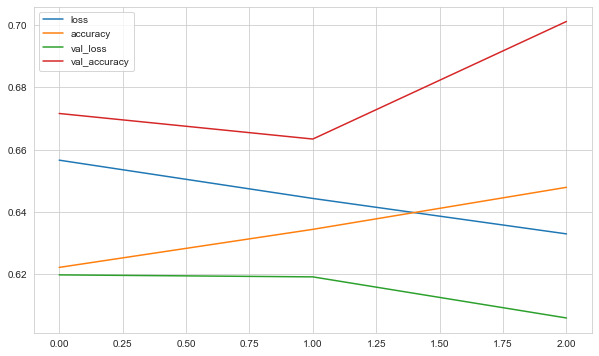

In [56]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()